# Experiment Design

### Story

We find out that there is a pain point on current design layout for users experience. Therefore, we are trying to revamp the current design so that we expect **the increase of CTR metric by at least 10%**.

### Metrics 

| Metric Type | Metric Name | Expectation |
| :-------- | :-------- | :--------: |
| Primary Metric    | CTR = clicks/views   | Increase   |
| Guardrail Metric    | views   | No decrease   |
| Secondary Metric    | clicks   | If the CTR increase then the Clicks should be increase as well|

### Launch Criteria 

We decide to Launch the treatment variant IF:
* CTR increase
* Views metric isn't decrease
* Clicks metric increase

### Determine Sample Size and Experiment Duration 

In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
cvr = 0.07 #conversion metric
mde = np.arange(0.05,1,0.05) #MDE for relative difference 0.1 - 0.9
alpha = 0.05 #alpha or significance level
power = 0.8 #statistical power
n_variant = 2
daily_traffic = 3000

In [3]:
variance = cvr*(1-cvr)
sample_per_variant = []

for mde_i in mde:
    delta = cvr*mde_i
    sample_per_variant.append((2*(norm.ppf(1 - alpha/2) + norm.ppf(power))**2)/(delta**2/variance))
    
duration_days = [i/daily_traffic for i in sample_per_variant]

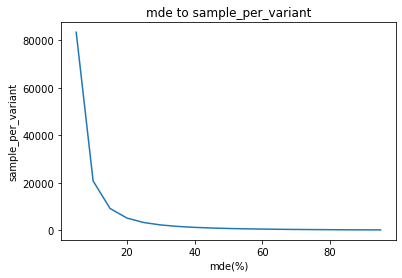

In [4]:
sns.lineplot(x=mde*100,y=sample_per_variant)
plt.title('mde to sample_per_variant')
plt.xlabel('mde(%)')
plt.ylabel('sample_per_variant')
plt.show()

In [5]:
result = pd.DataFrame({'mde(%)':mde*100,
              'sample_per_variant':np.ceil(sample_per_variant),
              'duration_days':np.ceil(duration_days)})

result

,mde(%),sample_per_variant,duration_days
0,5.0,83423.0,28.0
1,10.0,20856.0,7.0
2,15.0,9270.0,4.0
3,20.0,5214.0,2.0
4,25.0,3337.0,2.0
5,30.0,2318.0,1.0
6,35.0,1703.0,1.0
7,40.0,1304.0,1.0
8,45.0,1030.0,1.0
9,50.0,835.0,1.0


# Experiment Analysis

In [6]:
df = pd.read_csv('ab_test_results_aggregated_views_clicks.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  80000 non-null  int64  
 1   group    80000 non-null  object 
 2   views    80000 non-null  float64
 3   clicks   80000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.4+ MB


In [8]:
df.head()

,user_id,group,views,clicks
0,1,control,3.0,0.0
1,2,control,1.0,0.0
2,3,control,3.0,1.0
3,4,control,5.0,0.0
4,5,control,2.0,0.0


In [9]:
df.group.unique()

array(['control', 'test'], dtype=object)

## Sample Ratio Mismatch Checking (SRM)

In [10]:
df.groupby('group')['user_id'].nunique()

group
control    40000
test       40000
Name: user_id, dtype: int64

In [11]:
def sample_ratio_mismatch(control_sample_size, treatment_sample_size, 
                          control_expected_proportion, treatment_expected_proportion):
    
    total_sample_size = control_sample_size + treatment_sample_size
    
    # Compute the expected frequencies under the assumption of equal proportions
    expected_control_successes = control_expected_proportion * total_sample_size
    expected_treatment_successes = treatment_expected_proportion * total_sample_size
    
    # Create the observed and expected frequency arrays
    observed_frequencies = [control_sample_size, treatment_sample_size]
    expected_frequencies = [expected_control_successes, expected_treatment_successes]
    
    # Perform chi-square test to check for sample ratio mismatch
    _, p_value = stats.chisquare(observed_frequencies, expected_frequencies)
    
    # Check if the p-value is less than the significance level (e.g., 0.05)
    if p_value < 0.05:
        return True  # Sample ratio mismatch detected
    else:
        return False  # Sample ratio mismatch not detected

In [12]:
#Usage
control_expected_proportion = 0.5 
treatment_expected_proportion = 1-control_expected_proportion
control_sample_size = df.groupby('group')['user_id'].nunique()['control']
treatment_sample_size = df.groupby('group')['user_id'].nunique()['test']

if sample_ratio_mismatch(control_sample_size, treatment_sample_size, control_expected_proportion, treatment_expected_proportion):
    print("Sample ratio mismatch detected!")
else:
    print("Sample ratio mismatch not detected.")


Sample ratio mismatch not detected.


## Descriptive Analysis

In [13]:
# 1. Total users per variant_name
total_users = df.groupby('group')['user_id'].nunique()

# 2. Average clicks and views per variant_name
average_clicks = df.groupby('group')['clicks'].mean()
average_views = df.groupby('group')['views'].mean()

# 3. Total clicks / total views per variant_name
clicks_to_views_ratio = df.groupby('group').apply(lambda x: x['clicks'].sum() / x['views'].sum())

# 4. Median clicks and views per variant_name
median_clicks = df.groupby('group')['clicks'].median()
median_views = df.groupby('group')['views'].median()

# 4. Median clicks and views per variant_name
q3_clicks = df.groupby('group')['clicks'].quantile(0.90)
q3_views = df.groupby('group')['views'].quantile(0.90)

# Creating a new DataFrame to store the aggregated results
aggregated_data = pd.DataFrame({
    'Total Users': total_users,
    'Average Clicks': average_clicks,
    'Average Views': average_views,
    'Clicks to Views Ratio': clicks_to_views_ratio,
    'Median Clicks': median_clicks,
    'Median Views': median_views,
    'P90 Clicks':q3_clicks,
    'P90 Views':q3_views,
})

# Displaying the aggregated data
aggregated_data


,Total Users,Average Clicks,Average Views,Clicks to Views Ratio,Median Clicks,Median Views,P90 Clicks,P90 Views
group,,,,,,,,
control,40000,0.345725,4.981050,0.069408,0.0,3.0,1.0,10.0
test,40000,0.401150,5.015475,0.079982,0.0,3.0,1.0,10.0


## Inferential Analysis

**H<sub>0</sub> (null hypothesis)**: There is no difference between control and treatment variant

**H<sub>1</sub> (alternative hypothesis)**: There is a difference between control and treatment variant


In [14]:
from statsmodels.stats.proportion import proportions_ztest

def proportion_metric(control_view, control_click, treatment_view, treatment_click):
    count = np.array([control_click, treatment_click]) #numerator
    nobs = np.array([control_view, treatment_view]) #denom
    stat, pval = proportions_ztest(count, nobs)
    
    control_metric = control_click/control_view
    treatment_metric = treatment_click/treatment_view
    
    if pval <0.05: 
        significant_test = 'There is difference between control and treatment'
    else:
        significant_test = 'There is no difference between control and treatment'
    
    result = {'control':control_metric*100,
             'treatment':treatment_metric*100,
             '%difference':(treatment_metric - control_metric)*100/control_metric,
             'p-value':'{0:0.5f}'.format(pval),
             'conclusion':significant_test}

    return pd.DataFrame(result, index=[0])

def continuous_metric(control_data, treatment_data):
    stat, pval = stats.ttest_ind(control_data, treatment_data)
    
    if pval <0.05: 
        significant_test = 'There is difference between control and treatment'
    else:
        significant_test = 'There is no difference between control and treatment'
    
    result = {'control':control_data.mean(),
             'treatment':treatment_data.mean(),
             '%difference':(treatment_data.mean() - control_data.mean())*100/control_data.mean(),
             'p-value':'{0:0.5f}'.format(pval),
             'conclusion':significant_test}

    return pd.DataFrame(result, index=[0])


### Views Metric

In [15]:
control_data = df.loc[df['group']=='control','views']
treatment_data = df.loc[df['group']=='test','views']

result = continuous_metric(control_data, treatment_data)

result

,control,treatment,%difference,p-value,conclusion
0,4.98105,5.015475,0.691119,0.41051,There is no difference between control and tre...


### Clicks Metric

In [16]:
control_data = df.loc[df['group']=='control','clicks']
treatment_data = df.loc[df['group']=='test','clicks']

result = continuous_metric(control_data, treatment_data)

result

,control,treatment,%difference,p-value,conclusion
0,0.345725,0.40115,16.031528,0.00000,There is difference between control and treatment


### CTR Metric

In [17]:
control_view = df.loc[df['group']=='control','views'].sum()
control_click = df.loc[df['group']=='control','clicks'].sum()
treatment_view = df.loc[df['group']=='test','views'].sum()
treatment_click = df.loc[df['group']=='test','clicks'].sum()

result = proportion_metric(control_view, control_click, treatment_view, treatment_click)

result

,control,treatment,%difference,p-value,conclusion
0,6.940806,7.998245,15.235116,0.00000,There is difference between control and treatment


## Conclusion and Recommendation

Based on the experiment analysis, we find that:
* The treatment variant **increases the CTR by 15.23%**
* The Average Clicks also **increases by 16%**
* There is **no difference** of Views metric between control and treatment variant

The result of experiment fulfill the Launch Criteria, so we recommend to Launch the treatment variant.